In [525]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline as pip
from sklearn import preprocessing as pre
from sklearn import compose as com
from sklearn import impute as imp

from learntools.time_series.utils import seasonal_plot

from catboost import CatBoostRegressor


import xgboost.sklearn as xgb
import warnings
warnings.filterwarnings("ignore", message="is_sparse is deprecated")

In [526]:
df_holidays_events = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/holidays_events.csv')
df_oil = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/oil.csv')
df_stores = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/stores.csv')
df_train = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/train.csv')
df_transactions = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/transactions.csv')
df_test = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/test.csv')

In [527]:
#date format
df_train['date'] = pd.to_datetime(df_train['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [305]:
print('holidays_events.shape->', df_holidays_events.shape)
print('oil.shape->', df_oil.shape)
print('stores.shape->', df_stores.shape)
print('train.shape->', df_train.shape)
print('train.shape->', df_transactions.shape)

holidays_events.shape-> (350, 6)
oil.shape-> (1218, 2)
stores.shape-> (54, 5)
train.shape-> (3000888, 6)
train.shape-> (83488, 3)


In [306]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [307]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [308]:
df_holidays_events.shape

(350, 6)

In [309]:
#holiday
#for the transferred days
h_transferred_ones = df_holidays_events[(df_holidays_events['type'] == "Holiday") & (df_holidays_events['transferred'] == True)].drop("transferred", axis = 1).reset_index(drop = True)
h_transferred_days = df_holidays_events[(df_holidays_events['type'] == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
ht = pd.concat([h_transferred_ones, h_transferred_days], axis = 1)
ht = ht.iloc[:, [5,1,2,3,4]]

ht

,date,type,locale,locale_name,description
0,2012-10-12,Holiday,National,Ecuador,Independencia de Guayaquil
1,2013-10-11,Holiday,National,Ecuador,Independencia de Guayaquil
2,2014-10-10,Holiday,National,Ecuador,Independencia de Guayaquil
3,2016-05-27,Holiday,National,Ecuador,Batalla de Pichincha
4,2016-07-24,Holiday,Local,Guayaquil,Fundacion de Guayaquil
5,2016-08-12,Holiday,National,Ecuador,Primer Grito de Independencia
6,2017-01-02,Holiday,National,Ecuador,Primer dia del ano
7,2017-04-13,Holiday,Local,Cuenca,Fundacion de Cuenca
8,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha
9,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia


In [310]:
#holiday
#holidays to filter not (transferred ones, transferred dates)
df_holidays_events = df_holidays_events[(df_holidays_events['transferred'] == False) & (df_holidays_events['type'] != "Transfer")]

In [311]:
#add new days for transferred
df_holidays_events = pd.concat([df_holidays_events, ht], ignore_index=True)

In [312]:
df_holidays_events['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Bridge          5
Work Day        5
Name: count, dtype: int64

In [313]:
#holiday
#additional
df_holidays_events.loc[df_holidays_events['type'] == 'Additional', 'type'] = 'Holiday'

In [314]:
#bridge
df_holidays_events[(df_holidays_events['type'] == 'Bridge') | (df_holidays_events['type'] == 'Work Day')]


,date,type,locale,locale_name,description,transferred
33,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
37,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
40,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad,False
41,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano,False
143,2014-12-20,Work Day,National,Ecuador,Recupero Puente Navidad,False
150,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
154,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
155,2015-01-10,Work Day,National,Ecuador,Recupero Puente Primer dia del ano,False
265,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False
271,2016-11-12,Work Day,National,Ecuador,Recupero Puente Dia de Difuntos,False


In [315]:
df_holidays_events[df_holidays_events['type'] == 'Bridge']

,date,type,locale,locale_name,description,transferred
33,2012-12-24,Bridge,National,Ecuador,Puente Navidad,False
37,2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano,False
150,2014-12-26,Bridge,National,Ecuador,Puente Navidad,False
154,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano,False
265,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos,False


In [316]:
#expand the holiday dates for the bridge 

df_bridge = df_holidays_events[df_holidays_events['type'] == 'Bridge']

new_rows = []
for i in range(len(df_bridge)):
    # İlgili Pazartesi tarihini alalım
    current_date = df_bridge['date'].iloc[i]
    # Cuma'ya kadar olan tarihleri oluşturalım
    new_dates = pd.date_range(start=current_date, end=current_date + pd.DateOffset(days=4))
    # Yeni satırları oluşturalım
    for new_date in new_dates:
        new_row = {'date': new_date}
        # Diğer sütunlardaki verileri kopyalayalım
        for col in df_bridge.columns[1:]:
            new_row[col] = df_bridge[col].iloc[i]
        new_rows.append(new_row)

# Yeni satırları DataFrame'e ekleyelim
df_new_dates = pd.DataFrame(new_rows)
df_bridge = pd.concat([df_bridge, df_new_dates], ignore_index=True)


df_bridge = df_bridge.drop_duplicates()



In [317]:
df_holidays_events.shape

(338, 6)

In [318]:
df_holidays_events = df_holidays_events[df_holidays_events['type'] != 'Bridge']

In [319]:
df_holidays_events.shape

(333, 6)

In [320]:
df_bridge.shape

(25, 6)

In [321]:
df_holidays_events = pd.concat([df_holidays_events, df_bridge], ignore_index=True)

In [322]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [323]:
df_holidays_events['type'].value_counts()

type
Holiday     272
Event        56
Bridge       25
Work Day      5
Name: count, dtype: int64

In [324]:
df_holidays_events.loc[df_holidays_events['type'] == 'Bridge', 'type'] = 'Holiday'

In [325]:
df_holidays_events.loc[df_holidays_events['type'] == 'Event', 'type'] = 'Holiday'

In [326]:
df_holidays_events['type'].value_counts()

type
Holiday     353
Work Day      5
Name: count, dtype: int64

In [327]:
df_holidays_events['locale'].value_counts()

locale
National    186
Local       148
Regional     24
Name: count, dtype: int64

In [328]:
df_holidays_events.shape

(358, 6)

In [329]:
df_holidays_events[(df_holidays_events['locale'] != 'National')  ].shape

(172, 6)

In [330]:
nationals = df_holidays_events[(df_holidays_events['locale'] == 'National') & (df_holidays_events['type'] == 'Holiday') ]
df_holidays_events = df_holidays_events[(df_holidays_events['locale'] != 'National') | (df_holidays_events['type'] == 'Work Day')]

In [331]:
nationals.shape

(181, 6)

In [334]:
df_test.date.min()

Timestamp('2017-08-16 00:00:00')

In [335]:
df_test.date.max()

Timestamp('2017-08-31 00:00:00')

In [336]:
nationals[(nationals['date'] > df_test.date.min()) & (nationals['date'] < df_test.date.max()) ]

,date,type,locale,locale_name,description,transferred


In [337]:
#holiday nationals
nationals = nationals[['date','type']] ## Keep date & holiday type for merging
df_train=pd.merge(left=df_train, right=nationals, on='date', how='left')
df_test = pd.merge(left=df_test, right=nationals, on='date', how='left')

df_train.rename({'type':'is_holiday'},axis=1,inplace=True)
df_test.rename({'type':'is_holiday'},axis=1,inplace=True)

df_train['is_holiday'] = df_train.is_holiday.map({'Holiday':1}).fillna(0).astype('int8')
df_test['is_holiday'] = df_test.is_holiday.map({'Holiday':1}).fillna(0).astype('int8')


In [338]:
df_train['is_holiday'].value_counts()

is_holiday
0    2740716
1     269082
Name: count, dtype: int64

In [339]:
df_test['is_holiday'].value_counts()

is_holiday
0    28512
Name: count, dtype: int64

In [340]:
df_holidays_events['locale'].value_counts()

locale
Local       148
Regional     24
National      5
Name: count, dtype: int64

In [341]:
df_holidays_events['type'].value_counts()

type
Holiday     172
Work Day      5
Name: count, dtype: int64

In [344]:
workdays = df_holidays_events[df_holidays_events['type'] == 'Work Day']
df_holidays_events = df_holidays_events[df_holidays_events['type'] != 'Work Day']

In [347]:
local = df_holidays_events[df_holidays_events['locale'] == 'Local']
regional = df_holidays_events[df_holidays_events['locale'] == 'Regional']

In [348]:
local.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
5,2012-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False


In [351]:
df_merged = pd.merge(df_train, df_stores, on='store_nbr', how='left')
df_merged = pd.merge(df_merged, df_oil, on='date', how='left')
df_merged = pd.merge(df_merged, df_transactions, on=['date', 'store_nbr'], how='left')

In [372]:
df_test = pd.merge(df_test, df_stores, on='store_nbr', how='left')
df_test = pd.merge(df_test, df_oil, on='date', how='left')
df_test = pd.merge(df_test, df_transactions, on=['date', 'store_nbr'], how='left')

In [353]:
df_merged.head()

,id,date,store_nbr,family,sales,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
1,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
2,1,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
3,1,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
4,2,2013-01-01,1,BEAUTY,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN


In [355]:
df_merged['is_holiday'].value_counts()

is_holiday
0    2740716
1     269082
Name: count, dtype: int64

In [358]:
def check_match(row):
    if (row['date'] in local['date'].values) and (row['city'] in local['locale_name'].values):
        return 1
    else:
        return row['is_holiday']

df_merged['is_holiday'] = df_merged.apply(check_match, axis=1)


In [373]:
df_test['is_holiday'] = df_test.apply(check_match, axis=1)


In [374]:
df_test['is_holiday'].value_counts()

is_holiday
0    26829
1     1683
Name: count, dtype: int64

In [359]:
df_merged['is_holiday'].value_counts()

is_holiday
0    2580831
1     428967
Name: count, dtype: int64

In [361]:
df_merged['state'].value_counts()

state
Pichincha                         1059003
Guayas                             613107
Santo Domingo de los Tsachilas     167211
Azuay                              167211
Manabi                             167211
Cotopaxi                           111474
Tungurahua                         111474
Los Rios                           111474
El Oro                             111474
Chimborazo                          55737
Imbabura                            55737
Bolivar                             55737
Pastaza                             55737
Santa Elena                         55737
Loja                                55737
Esmeraldas                          55737
Name: count, dtype: int64

In [367]:
def check_match_reg(row):
    if (row['date'] in regional['date'].values) and (row['state'] in regional['locale_name'].values):
        return 1
    else:
        return row['is_holiday']

df_merged['is_holiday'] = df_merged.apply(check_match_reg, axis=1)

In [375]:
df_test['is_holiday'] = df_test.apply(check_match_reg, axis=1)

In [376]:
df_test['is_holiday'].value_counts()

is_holiday
0    26829
1     1683
Name: count, dtype: int64

In [368]:
df_merged['is_holiday'].value_counts()

is_holiday
0    2578290
1     431508
Name: count, dtype: int64

In [377]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [370]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [371]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1
1,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1
2,1,2013-01-01,1,BABY CARE,0.0,0,1
3,1,2013-01-01,1,BABY CARE,0.0,0,1
4,2,2013-01-01,1,BEAUTY,0.0,0,1


In [113]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [114]:
df_test.shape

(28512, 5)

In [378]:
df_test.head()

,id,date,store_nbr,family,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,0,0,Quito,Pichincha,D,13,46.8,NaN
1,3000889,2017-08-16,1,BABY CARE,0,0,Quito,Pichincha,D,13,46.8,NaN
2,3000890,2017-08-16,1,BEAUTY,2,0,Quito,Pichincha,D,13,46.8,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,0,Quito,Pichincha,D,13,46.8,NaN
4,3000892,2017-08-16,1,BOOKS,0,0,Quito,Pichincha,D,13,46.8,NaN


In [379]:
df_merged.head()

,id,date,store_nbr,family,sales,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
1,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
2,1,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
3,1,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN
4,2,2013-01-01,1,BEAUTY,0.0,0,1,Quito,Pichincha,D,13,NaN,NaN


In [380]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009798 entries, 0 to 3009797
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   is_holiday    int64         
 7   city          object        
 8   state         object        
 9   type          object        
 10  cluster       int64         
 11  dcoilwtico    float64       
 12  transactions  float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 298.5+ MB


<Axes: >

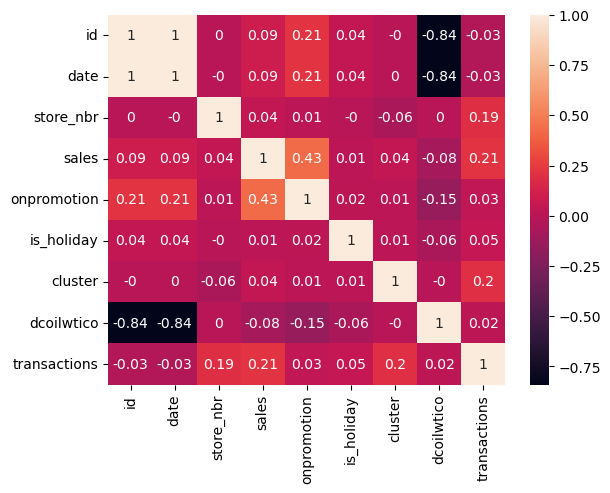

In [381]:
sns.heatmap( np.round(df_merged.select_dtypes(exclude='object').corr(), 2), annot=True)

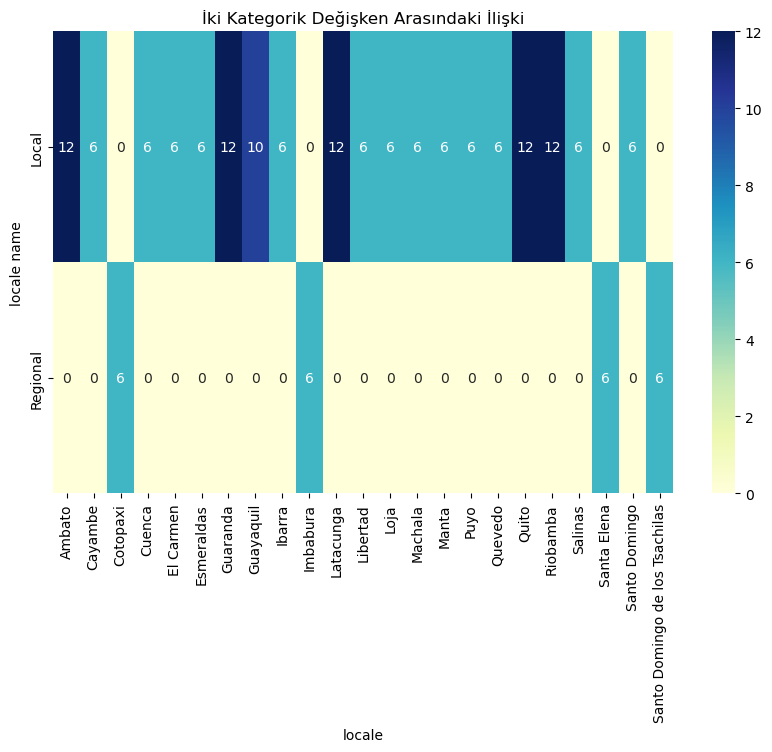

In [382]:
# İki kategorik değişkenin birleşim frekanslarını hesapla
cross_tab = pd.crosstab(df_holidays_events['locale'], df_holidays_events['locale_name'])

# Heatmap oluştur
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('İki Kategorik Değişken Arasındaki İlişki')
plt.xlabel('locale')
plt.ylabel('locale name')
plt.show()

In [383]:
df_merged.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
is_holiday           0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      935550
transactions    247830
dtype: int64

In [384]:
df_merged['date'].nunique()

1684

In [385]:
#since we merged df_transactions via store_nbr and date, unique numbers of null date does not mean anything
df_merged[df_merged.transactions.isnull()]['date'].nunique()

1566

In [386]:
#since we dont have the values for the dates of the test data, we can ignore transactions
df_transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [387]:
df_merged.drop('transactions', axis=1,inplace=True)

In [389]:
df_test.drop('transactions', axis=1,inplace=True)

In [390]:
df_merged.drop('id', axis=1,inplace=True)
df_test.drop('id', axis=1,inplace=True)

In [391]:
df_merged[df_merged.dcoilwtico.notnull()]['date'].nunique()

1163

In [392]:
df_merged[df_merged.dcoilwtico.isnull()]['date'].nunique()

521

In [393]:
df_merged.head()

,date,store_nbr,family,sales,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN
1,2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN
2,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN
3,2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN
4,2013-01-01,1,BEAUTY,0.0,0,1,Quito,Pichincha,D,13,NaN


In [394]:
df_merged.isna().sum()

date                0
store_nbr           0
family              0
sales               0
onpromotion         0
is_holiday          0
city                0
state               0
type                0
cluster             0
dcoilwtico     935550
dtype: int64

In [395]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [397]:
indices = pd.date_range(df_merged.date.min(), df_merged.date.max(), freq="D").difference(df_merged.date)
print('Missing indices\n:', indices)



Missing indices
: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [398]:
def date_parse(df):
    df['date'] = pd.to_datetime(df['date'])
    df['DayOfWeek'] = df['date'].dt.dayofweek
    #df['Week'] = df['date'].dt.week
    df['Month'] = df['date'].dt.month
    df["Quarter"] = df["date"].dt.quarter
    df["Year"] = df["date"].dt.year
    #df["WeekOfYear"] = df["date"].dt.weekofyear
    return df

In [399]:
def cycle_encode(data, cols):
    for col in cols:
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
    return data

In [400]:
df_merged = date_parse(df_merged)
df_merged = cycle_encode(df_merged, ['DayOfWeek', 'Month', 'Quarter'])

In [401]:
df_test = date_parse(df_test)
df_test = cycle_encode(df_test, ['DayOfWeek', 'Month', 'Quarter'])

In [402]:
df_merged.drop(['DayOfWeek', 'Month', 'Quarter'], axis=1, inplace=True)

In [403]:
df_test.drop(['DayOfWeek', 'Month', 'Quarter'], axis=1, inplace=True)

In [404]:
df_merged

,date,store_nbr,family,sales,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
1,2013-01-01,1,AUTOMOTIVE,0.000,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
2,2013-01-01,1,BABY CARE,0.000,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
3,2013-01-01,1,BABY CARE,0.000,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
4,2013-01-01,1,BEAUTY,0.000,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009793,2017-08-15,9,POULTRY,438.133,0,1,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16
3009794,2017-08-15,9,PREPARED FOODS,154.553,1,1,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16
3009795,2017-08-15,9,PRODUCE,2419.729,148,1,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16
3009796,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,1,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16


In [405]:
df_merged = df_merged.set_index('date')

In [406]:
df_test = df_test.set_index('date')

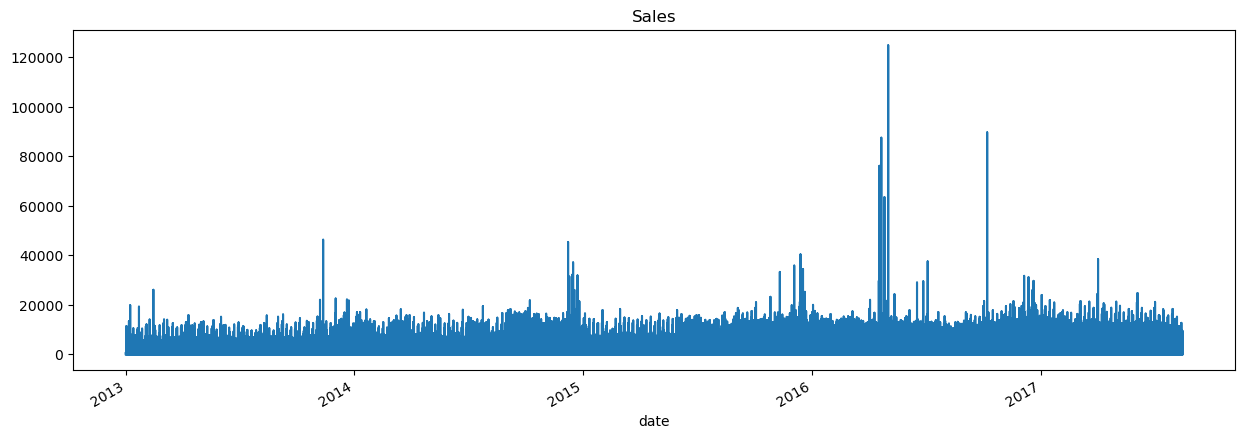

In [407]:
fig, ax = plt.subplots(figsize=(15, 5))
df_merged.sales.plot(ax=ax, label='Training Set', title='Sales')
plt.show()

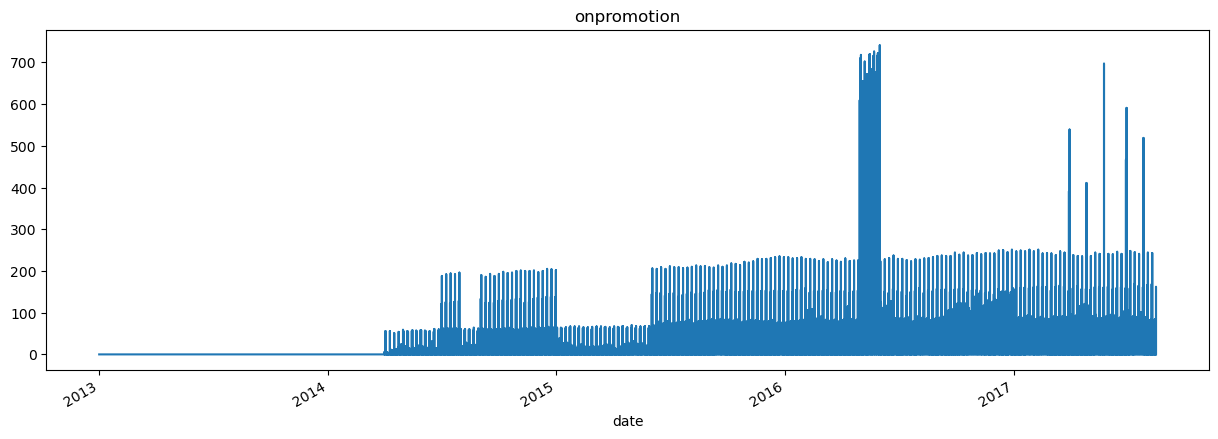

In [408]:
fig, ax = plt.subplots(figsize=(15, 5))
df_merged.onpromotion.plot(ax=ax, label='Training Set', title='onpromotion')
plt.show()

In [409]:
len(df_merged['store_nbr'].value_counts())

54

In [410]:
df_merged['family'].value_counts()

family
AUTOMOTIVE                    91206
HOME APPLIANCES               91206
SCHOOL AND OFFICE SUPPLIES    91206
PRODUCE                       91206
PREPARED FOODS                91206
POULTRY                       91206
PLAYERS AND ELECTRONICS       91206
PET SUPPLIES                  91206
PERSONAL CARE                 91206
MEATS                         91206
MAGAZINES                     91206
LIQUOR,WINE,BEER              91206
LINGERIE                      91206
LAWN AND GARDEN               91206
LADIESWEAR                    91206
HOME CARE                     91206
HOME AND KITCHEN II           91206
BABY CARE                     91206
HOME AND KITCHEN I            91206
HARDWARE                      91206
GROCERY II                    91206
GROCERY I                     91206
FROZEN FOODS                  91206
EGGS                          91206
DELI                          91206
DAIRY                         91206
CLEANING                      91206
CELEBRATION          

In [411]:
df_merged.head()

,store_nbr,family,sales,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
date,,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,AUTOMOTIVE,0.0,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BABY CARE,0.0,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BEAUTY,0.0,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17


In [412]:
df_merged['store_nbr'] = df_merged['store_nbr'].astype('object')

In [413]:
df_test['store_nbr'] = df_test['store_nbr'].astype('object')

In [414]:
X = df_merged.drop('sales', axis=1)
y = df_merged['sales']

In [415]:
cat_columns = X.select_dtypes(include='object').columns.values
num_columns = X.select_dtypes(exclude='object').columns.values

In [416]:
X.head()

,store_nbr,family,onpromotion,is_holiday,city,state,type,cluster,dcoilwtico,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
date,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,AUTOMOTIVE,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BABY CARE,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BABY CARE,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BEAUTY,0,1,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17


In [507]:
df_train.groupby('date')['sales'].mean().squeeze().loc['2017'].to_frame()

,sales
date,
2017-01-01,6.780304
2017-01-02,786.928379
2017-01-03,619.740224
2017-01-04,555.608004
2017-01-05,436.375395
...,...
2017-08-11,463.733851
2017-08-12,444.798280
2017-08-13,485.768618


In [508]:
df_train.unstack(['store_nbr', 'family'])

KeyError: 'Requested level (store_nbr) does not match index name (None)'

In [499]:
X['DayOfWeek_sin'].value_counts()

DayOfWeek_sin
 8.660254e-01    433026
-8.660254e-01    431244
-2.449294e-16    431244
-8.660254e-01    429462
 0.000000e+00    429462
 8.660254e-01    427680
 1.224647e-16    427680
Name: count, dtype: int64

In [417]:
len(X['family'].value_counts()), len(X['city'].value_counts()),len(X['state'].value_counts()),len(X['store_nbr'].value_counts())

(33, 22, 16, 54)

In [484]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

pip_num = pip.Pipeline([
    ('scaler', pre.StandardScaler()),
    ('imputer', imp.SimpleImputer())
])

pip_cat = pip.Pipeline([
    ('encoder', pre.OneHotEncoder(handle_unknown='ignore')),
])

ct = com.ColumnTransformer([
    ('num', pip_num, num_columns),
    ('cat', pip_cat, cat_columns)
])

pip_final = pip.Pipeline([
    ('ct', ct),
    ('model', XGBRegressor())
])

#######
from sklearn.metrics import make_scorer

# RMSLE skorlama fonksiyonunu tanımlama
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Tahminler ve gerçek değerler aynı uzunlukta olmalıdır."
    squared_errors = (np.log1p(y_true) - np.log1p(y_pred)) ** 2
    mean_squared_errors = np.mean(squared_errors)
    rmsle_score = np.sqrt(mean_squared_errors)
    return -rmsle_score  # RMSLE'yi minimize etmek için negatifini alıyoruz

# RMSLE skorlama fonksiyonunu make_scorer ile özel bir skorlama objesine dönüştürme
rmsle_scorer = make_scorer(rmsle)
##########


# set the parameters
params = {
    
    'model__learning_rate':[0.001,0.1,0.3,0.5,1],
    'model__min_child_weight': [1, 5, 10],
    'model__gamma': [0.5, 1, 1.5, 2, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__max_depth': [3, 4, 5,7]
        }

#grid = GridSearchCV(pip_final,
#                    param_grid = params,
#                    scoring = rmsle_scorer,
#                    cv = TimeSeriesSplit(n_splits=3),
#                   )
random_search = RandomizedSearchCV(pip_final, param_distributions=params, scoring='neg_mean_absolute_error', n_jobs=4, cv=3, verbose=3,  )

In [485]:
random_search.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/olcaycezayir/anaconda3/envs/tf/lib/python3.11/site-packages/xgboost/data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/olcaycezayir/anaconda3/envs/t

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ct',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler()),
                                                                                               ('imputer',
                                                                                                SimpleImputer())]),
                                                                               array(['onpromotion', 'is_holiday', 'cluster', 'dcoilwtico', 'Year',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos',
       'Quarter_sin', 'Quarter_cos'], dtype=object)),
                                                                              ('cat',
                                                                               Pipeline(s...
                                                           num_parallel_tree=None,
                                                           predictor=None,
                                                           random_state=None, ...))]),
                   n_jobs=4,
                   param_distributions={'model__colsample_bytree': [0.6, 0.8,
                                                                    1.0],
                                        'model__gamma': [0.5, 1, 1.5, 2, 5],
                                        'model__learning_rate': [0.001, 0.1,
                                                                 0.3, 0.5, 1],
                                        'model__max_depth': [3, 4, 5, 7],
                                        'model__min_child_weight': [1, 5, 10],
                                        'model__subsample': [0.6, 0.8, 1.0]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [496]:
print(random_search.best_score_ * 2 - 1)

-288.68170686951765


In [486]:
random_search.best_score_

-143.84085343475883

In [487]:
random_search.best_params_

{'model__subsample': 0.6,
 'model__min_child_weight': 5,
 'model__max_depth': 7,
 'model__learning_rate': 0.3,
 'model__gamma': 2,
 'model__colsample_bytree': 1.0}

In [488]:
y_pred = random_search.predict(df_test)

In [489]:
type(y_pred)

numpy.ndarray

In [490]:
df_test_id = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/test.csv')

In [491]:
result10 = pd.DataFrame({'id': df_test_id['id'], 'sales': y_pred})
result10.head()

,id,sales
0,3000888,17.764256
1,3000889,14.736806
2,3000890,13.506725
3,3000891,2752.621094
4,3000892,16.313484


In [495]:
(result10['sales']<0).sum()

2885

[CV 2/3] END model__colsample_bytree=1.0, model__gamma=1.5, model__learning_rate=0.001, model__max_depth=3, model__min_child_weight=10, model__subsample=1.0;, score=-355.893 total time= 1.1min
[CV 3/3] END model__colsample_bytree=1.0, model__gamma=0.5, model__learning_rate=0.001, model__max_depth=7, model__min_child_weight=10, model__subsample=1.0;, score=-427.595 total time= 2.3min
[CV 2/3] END model__colsample_bytree=1.0, model__gamma=2, model__learning_rate=0.3, model__max_depth=7, model__min_child_weight=5, model__subsample=0.6;, score=-133.929 total time= 2.6min
[CV 1/3] END model__colsample_bytree=0.8, model__gamma=0.5, model__learning_rate=0.001, model__max_depth=4, model__min_child_weight=10, model__subsample=0.6;, score=-234.123 total time= 1.3min
[CV 1/3] END model__colsample_bytree=1.0, model__gamma=2, model__learning_rate=0.3, model__max_depth=3, model__min_child_weight=5, model__subsample=0.6;, score=-195.818 total time= 1.2min
[CV 1/3] END model__colsample_bytree=0.8, mod

In [475]:
#result9.loc[result9['sales']<0, 'sales'] = 0

In [493]:
result10.to_csv('result10.csv', index=False)
